In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import os


In [2]:
# Define the directory where the notebook is located
script_dir = os.getcwd()

# Load the dataset from the same directory
data_path = os.path.join(script_dir, "student_productivity.csv")
data = pd.read_csv(data_path)


In [3]:
# Convert 'day_of_week' and 'time_of_day' to numerical values
data['day_of_week'] = data['day_of_week'].map({
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
})
data['time_of_day'] = data['time_of_day'].str.replace(':00', '').astype(int)

# Create 4-hour slots
def get_time_slot(hour):
    if 0 <= hour < 4:
        return 0
    elif 4 <= hour < 8:
        return 1
    elif 8 <= hour < 12:
        return 2
    elif 12 <= hour < 16:
        return 3
    elif 16 <= hour < 20:
        return 4
    else:
        return 5

data['time_slot'] = data['time_of_day'].apply(get_time_slot)


In [4]:
# Split features and target
X = data[['day_of_week', 'time_slot']]
y = data['productivity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Step 1: RandomForest Regressor for Initial Predictions
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict productivity on the entire dataset
data['rf_predicted_productivity'] = rf_model.predict(X)


In [6]:
# Step 2: Preparing Data for LSTM
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['day_of_week', 'time_slot', 'rf_predicted_productivity']])

# Reshape for LSTM (samples, time steps, features)
sequence_length = 6
X_lstm, y_lstm = [], []
for i in range(len(scaled_data) - sequence_length):
    X_lstm.append(scaled_data[i:i + sequence_length, :2])  # Use day_of_week, time_slot as features
    y_lstm.append(scaled_data[i + sequence_length, 2])  # Use rf_predicted_productivity as target

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)


In [7]:
# Split data into training and testing sets for LSTM
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]


In [8]:
# Step 3: Build the LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(sequence_length, 2)))
lstm_model.add(LSTM(units=32))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)


Epoch 1/10
438/438 [==============================] - 4s 4ms/step - loss: 0.0576
Epoch 2/10
438/438 [==============================] - 2s 4ms/step - loss: 0.0117
Epoch 3/10
438/438 [==============================] - 2s 5ms/step - loss: 0.0059
Epoch 4/10
438/438 [==============================] - 2s 4ms/step - loss: 0.0036
Epoch 5/10
438/438 [==============================] - 2s 4ms/step - loss: 0.0031
Epoch 6/10
438/438 [==============================] - 2s 4ms/step - loss: 0.0029
Epoch 7/10
438/438 [==============================] - 2s 4ms/step - loss: 0.0027
Epoch 8/10
438/438 [==============================] - 2s 4ms/step - loss: 0.0017
Epoch 9/10
438/438 [==============================] - 2s 4ms/step - loss: 8.8902e-04
Epoch 10/10
438/438 [==============================] - 2s 4ms/step - loss: 5.4500e-04


In [9]:
# Step 4: Evaluating LSTM Model
y_pred_lstm = lstm_model.predict(X_test_lstm)
lstm_mse = mean_squared_error(y_test_lstm, y_pred_lstm)
print(f'LSTM Model Mean Squared Error: {lstm_mse}')


110/110 [==============================] - 1s 2ms/step
LSTM Model Mean Squared Error: 0.0002444027845133728


In [10]:
# Step 5: Predicting Productivity for Entire Dataset Using LSTM
data['lstm_predicted_productivity'] = np.nan
predictions_lstm = lstm_model.predict(X_lstm)
data['lstm_predicted_productivity'].iloc[sequence_length:] = predictions_lstm.flatten()

# Save the average productivity predictions
output_path = os.path.join(script_dir, "merged_model_predictions.csv")
data.to_csv(output_path, index=False)


548/548 [==============================] - 1s 1ms/step


C:\Users\Ashvik Mishra\AppData\Local\Temp\ipykernel_17752\2689769729.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lstm_predicted_productivity'].iloc[sequence_length:] = predictions_lstm.flatten()


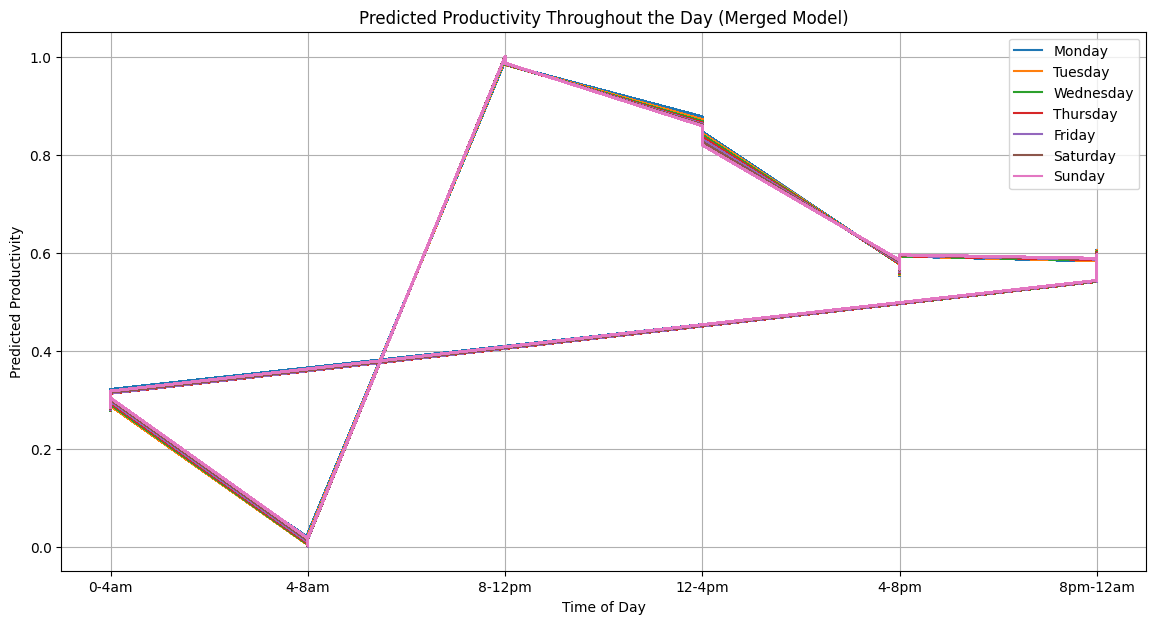

In [11]:
# Step 6: Plot Productivity Predictions (LSTM + RandomForest)
plt.figure(figsize=(14, 7))
time_labels = ['0-4am', '4-8am', '8-12pm', '12-4pm', '4-8pm', '8pm-12am']
for day in range(7):
    day_data = data[data['day_of_week'] == day]
    plt.plot(day_data['time_slot'] * 4, day_data['lstm_predicted_productivity'], label=f'Day {day}')

plt.xticks(ticks=[0, 4, 8, 12, 16, 20], labels=time_labels)
plt.xlabel('Time of Day')
plt.ylabel('Predicted Productivity')
plt.title('Predicted Productivity Throughout the Day (Merged Model)')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)
plt.show()
